# 🧠 CHURN DETECTION PROJECT

## 1. Import Libraries
## 2. Load & Explore Data
## 3. Preprocess Data
## 4. Train Models
## 5. Evaluate
## 6. Feature Importance (SHAP)
## 7. Save Model
## 8. Push Notebook to GitHub

# Cell 1 — Setup & Imports

In [1]:
# Install missing packages (just in case)
!pip install shap xgboost joblib --quiet

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
)

from xgboost import XGBClassifier
import shap
import joblib
import os


# Cell 2 — Load Dataset (Telco Churn Dataset)

In [2]:
# Load dataset (Kaggle auto-mounts it under /kaggle/input)
df = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
print("✅ Dataset loaded successfully!")
df.head()

✅ Dataset loaded successfully!


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Cell 3 — EDA (Quick Checks)

Dataset shape: (7043, 21)

Missing values:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Churn distribution:
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


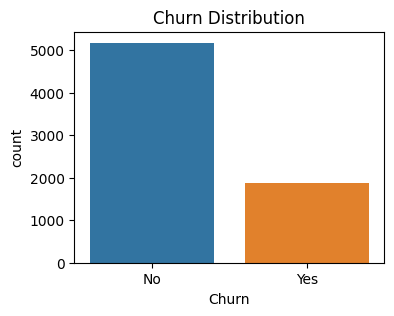

In [3]:
print("Dataset shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())
print("\nChurn distribution:")
print(df['Churn'].value_counts(normalize=True))

plt.figure(figsize=(4,3))
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()

# Cell 4 — Data Cleaning

In [4]:
# Convert TotalCharges to numeric and fill NaNs
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Map churn to 0/1
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Drop customerID (not a predictive feature)
df.drop('customerID', axis=1, inplace=True)

print("✅ Data cleaned!")
df.head()


✅ Data cleaned!


A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


# Cell 5 — Encode Categorical Columns

In [5]:
# Identify categorical and numeric columns
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(exclude=['object']).columns

# One-hot encoding for categorical features
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print(f"Encoded dataset shape: {df_encoded.shape}")
df_encoded.head()


Encoded dataset shape: (7043, 31)


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,0,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,1840.75,0,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,0,2,70.70,151.65,1,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


# Cell 6 — Train/Test Split

In [6]:
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (5634, 30)
Test shape: (1409, 30)


# Cell 7 - Baseline Logistic Regression

Logistic Regression AUC: 0.842664496628691
              precision    recall  f1-score   support

           0       0.90      0.73      0.80      1035
           1       0.51      0.78      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



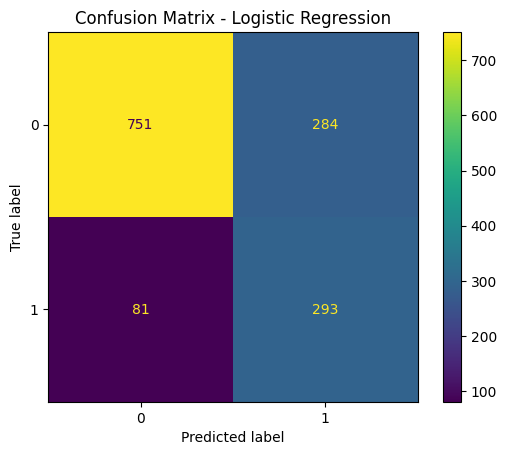

In [7]:
log_model = LogisticRegression(max_iter=1000, class_weight='balanced')
log_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:,1]

print("Logistic Regression AUC:", roc_auc_score(y_test, y_prob_log))
print(classification_report(y_test, y_pred_log))

ConfusionMatrixDisplay.from_estimator(log_model, X_test, y_test)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


# Cell 8 — XGBoost Classifier

XGBoost AUC: 0.8257162417008964
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1035
           1       0.61      0.53      0.57       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



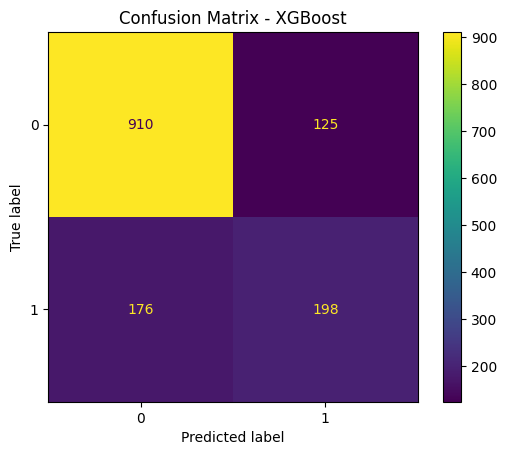

In [8]:
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:,1]

print("XGBoost AUC:", roc_auc_score(y_test, y_prob_xgb))
print(classification_report(y_test, y_pred_xgb))

ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test)
plt.title("Confusion Matrix - XGBoost")
plt.show()


# Cell 9 — Feature Importance

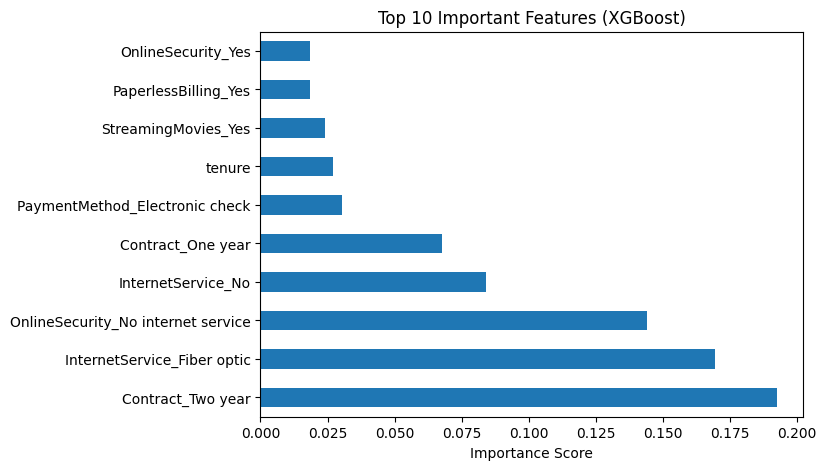

In [9]:
importances = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(7,5))
importances.head(10).plot(kind='barh')
plt.title("Top 10 Important Features (XGBoost)")
plt.xlabel("Importance Score")
plt.show()


# Cell 10 — Explainability with SHAP

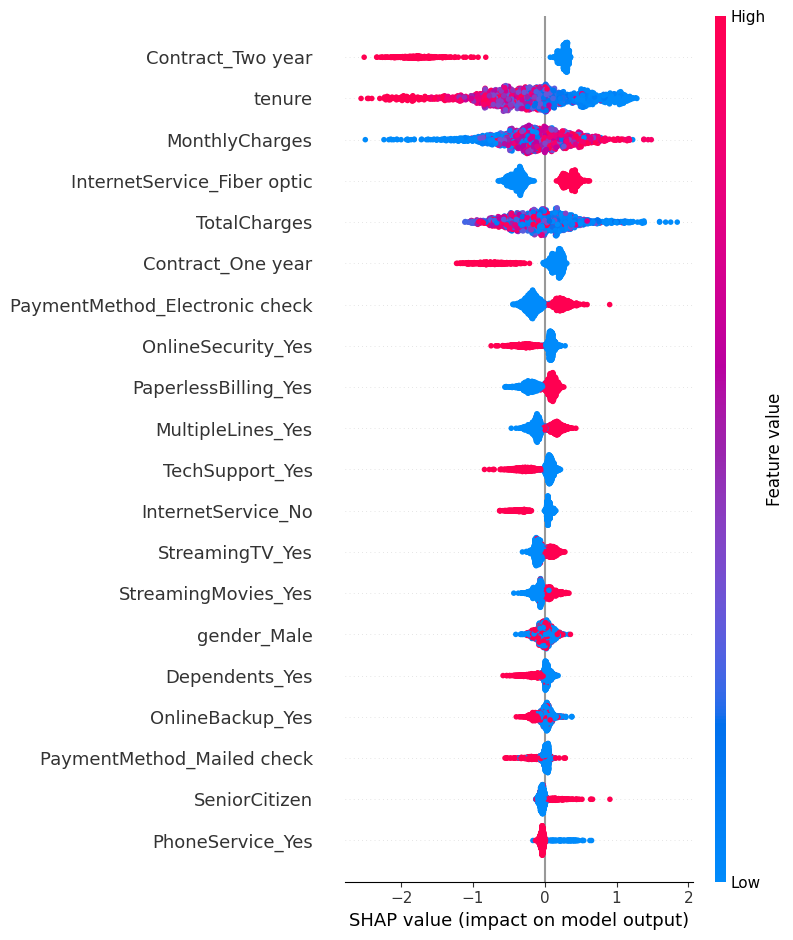

In [10]:
shap.initjs()
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Global importance
shap.summary_plot(shap_values, X_test)


# Cell 11 — Save Trained Models

In [11]:
# Create model directory
os.makedirs("/kaggle/working/models", exist_ok=True)

joblib.dump(log_model, "/kaggle/working/models/logistic_churn.pkl")
joblib.dump(xgb_model, "/kaggle/working/models/xgb_churn.pkl")

print("✅ Models saved in /kaggle/working/models/")


✅ Models saved in /kaggle/working/models/


# Cell 12 — Predict for a Single Sample

In [12]:
sample = X_test.iloc[[0]]
pred_prob = xgb_model.predict_proba(sample)[:,1][0]
print(f"Predicted churn probability: {pred_prob:.3f}")


Predicted churn probability: 0.003


# Cell 13 — Create a README for GitHub (auto)

In [13]:
readme_text = """
# 🧠 Churn Detection Project (Kaggle + GitHub)
Predicting customer churn using the Telco dataset.

## 📊 Overview
This project predicts customer churn using machine learning models (Logistic Regression & XGBoost)
and explains key drivers using SHAP values.

## 🚀 Steps
1. Data Cleaning & EDA
2. Model Training (LogReg, XGBoost)
3. Evaluation (AUC, Classification Report)
4. SHAP Explainability
5. Model Saving

## 📈 Dataset
[Telco Customer Churn - Kaggle](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)

## 🧰 Libraries
pandas, numpy, scikit-learn, xgboost, shap, joblib, seaborn, matplotlib
"""
with open("/kaggle/working/README.md", "w") as f:
    f.write(readme_text)

print("✅ README.md created in /kaggle/working/")


✅ README.md created in /kaggle/working/


# Fine Tuning after seeing results 

# SECTION 1: HYPERPARAMETER TUNING (4 WAYS)

# 1️⃣ Manual tuning using for loops (simple + interpretable)

In [14]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

best_auc = 0
best_params = None

for lr in [0.01, 0.05, 0.1]:
    for depth in [4, 6, 8]:
        for subsample in [0.7, 0.8, 1.0]:
            xgb_model = XGBClassifier(
                n_estimators=400,
                learning_rate=lr,
                max_depth=depth,
                subsample=subsample,
                colsample_bytree=0.8,
                random_state=42,
                eval_metric='logloss',
                use_label_encoder=False
            )
            xgb_model.fit(X_train, y_train)
            auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1])
            if auc > best_auc:
                best_auc = auc
                best_params = (lr, depth, subsample)
print("Best AUC:", best_auc)
print("Best Params (lr, depth, subsample):", best_params)


Best AUC: 0.848177426438296
Best Params (lr, depth, subsample): (0.01, 4, 0.7)


# 2️⃣ GridSearchCV (classic tuning)

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'n_estimators': [200, 300, 400],
    'subsample': [0.8, 1.0],
}

grid = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best Params:", grid.best_params_)
print("Best AUC:", grid.best_score_)

Best Params: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 400, 'subsample': 0.8}
Best AUC: 0.848554215860031


# 3️⃣ RandomizedSearchCV (faster tuning)

In [16]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_dist = {
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': [3,4,5,6,7,8],
    'n_estimators': [100, 200, 400, 600],
    'subsample': np.linspace(0.6, 1.0, 5),
    'colsample_bytree': np.linspace(0.6, 1.0, 5)
}

random_search = RandomizedSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    param_distributions=param_dist,
    n_iter=30,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)
print("Best Params:", random_search.best_params_)
print("Best AUC:", random_search.best_score_)
    

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Params: {'subsample': 0.9, 'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Best AUC: 0.8485907066552485


# 4️⃣ Optuna (modern Bayesian optimization)

In [17]:
!pip install optuna --quiet
import optuna
from sklearn.metrics import roc_auc_score

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 600),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'random_state': 42
    }
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_test)[:,1]
    return roc_auc_score(y_test, preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
print("Best trial:", study.best_trial.params)

[I 2025-11-12 13:16:48,585] A new study created in memory with name: no-name-52582465-ec45-4953-9d17-1de9c9b92675
[I 2025-11-12 13:16:48,723] Trial 0 finished with value: 0.8437391821023534 and parameters: {'n_estimators': 264, 'learning_rate': 0.2605468697706719, 'max_depth': 8, 'subsample': 0.6633891383568199, 'colsample_bytree': 0.776857623057964, 'gamma': 3.551778114133344}. Best is trial 0 with value: 0.8437391821023534.
[I 2025-11-12 13:16:48,842] Trial 1 finished with value: 0.8453925443695265 and parameters: {'n_estimators': 275, 'learning_rate': 0.23115401130621896, 'max_depth': 4, 'subsample': 0.9416406879721675, 'colsample_bytree': 0.9267548620898606, 'gamma': 2.4999081960309084}. Best is trial 1 with value: 0.8453925443695265.
[I 2025-11-12 13:16:49,161] Trial 2 finished with value: 0.8274354801209023 and parameters: {'n_estimators': 597, 'learning_rate': 0.1355775880094419, 'max_depth': 9, 'subsample': 0.7622960394013789, 'colsample_bytree': 0.9504864743400115, 'gamma': 1.

Best trial: {'n_estimators': 200, 'learning_rate': 0.01886588359725827, 'max_depth': 5, 'subsample': 0.7107678557633956, 'colsample_bytree': 0.7167802437884917, 'gamma': 3.2126444200338238}


# 🚀 SECTION 2: ADVANCED MODELS (Beyond XGBoost)

# 1️⃣ LightGBM

In [18]:
!pip install lightgbm --quiet
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

lgb_model = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    num_leaves=32,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgb_model.fit(X_train, y_train)
y_prob_lgb = lgb_model.predict_proba(X_test)[:,1]
print("LightGBM AUC:", roc_auc_score(y_test, y_prob_lgb))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

# 2️⃣ CatBoost

In [19]:
!pip install catboost --quiet
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(
    iterations=400,
    learning_rate=0.05,
    depth=6,
    eval_metric='AUC',
    random_state=42,
    verbose=0
)
cat_model.fit(X_train, y_train)
y_prob_cat = cat_model.predict_proba(X_test)[:,1]
print("CatBoost AUC:", roc_auc_score(y_test, y_prob_cat))

CatBoost AUC: 0.8398744478028366


# 3️⃣ ExtraTreesClassifier

In [20]:
from sklearn.ensemble import ExtraTreesClassifier

et_model = ExtraTreesClassifier(n_estimators=400, random_state=42, class_weight='balanced')
et_model.fit(X_train, y_train)
y_prob_et = et_model.predict_proba(X_test)[:,1]
print("Extra Trees AUC:", roc_auc_score(y_test, y_prob_et))


Extra Trees AUC: 0.8021687462863933


# 📈 SECTION 3: REGRESSION MODELS (Predict how many will churn)

# 1️⃣ Regression with aggregated targets

In [21]:
# Example: aggregate by 'Contract' type
agg = df.groupby('Contract')['Churn'].agg(['mean', 'count'])
agg['churn_count'] = agg['mean'] * agg['count']
agg

,mean,count,churn_count
Contract,,,
Month-to-month,0.427097,3875,1655.0
One year,0.112695,1473,166.0
Two year,0.028319,1695,48.0


# 2️⃣ Poisson Regression (count modeling)

In [22]:
from sklearn.linear_model import PoissonRegressor
import numpy as np

# Example: simulate counts by grouping (e.g., tenure)
df_reg = df.copy()
df_reg['tenure_bucket'] = pd.cut(df_reg['tenure'], bins=10)

agg = df_reg.groupby('tenure_bucket')['Churn'].agg(['sum', 'count']).reset_index()
agg.rename(columns={'sum': 'churn_count', 'count': 'total_customers'}, inplace=True)

Xr = agg[['total_customers']]
yr = agg['churn_count']

poisson = PoissonRegressor(alpha=1e-3)
poisson.fit(Xr, yr)

pred_counts = poisson.predict(Xr)
print(pd.DataFrame({'actual': yr, 'predicted': pred_counts.round(1)}))


   actual  predicted
0     835      186.9
1     264      186.9
2     169      186.9
3     126      186.9
4     117      186.9
5      98      186.9
6      72      186.9
7      70      186.9
8      46      186.9
9      72      186.9


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


# 3️⃣ Regression on churn probability (continuous)

In [23]:
from sklearn.ensemble import GradientBoostingRegressor

# Here, predict churn rate for groups
Xr = agg[['total_customers']]
yr = agg['churn_count'] / agg['total_customers']

reg = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05)
reg.fit(Xr, yr)
print("R² score:", reg.score(Xr, yr))


R² score: 0.9999999877448068
